<a href="https://colab.research.google.com/github/ggsmith842/AIML-tutorials/blob/main/pytorch/text/NLP_From_Scratch_Classifying_Names_with_a_Character_Level_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: [pytorch.org/tutorials/classification_tutorial](https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [6]:
# Prepare the data
import string
import unicodedata


# oov chars represented by '_'
allowed_chars = string.ascii_letters + ".,;'" + "_"
n_letters = len(allowed_chars)

In [7]:
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s) # NFD stands for Normalization Form Canonical Decomposition
      if unicodedata.category(c)!= 'Mn' # 'Mn' stands for "Mark, nonspacing," which includes characters like accent marks
      and c in allowed_chars
  )

In [8]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


# Turning Names into Tensors

In [9]:
def letterToIndex(letter):
  if letter not in allowed_chars:
    return allowed_chars.find("_")
  else:
    return allowed_chars.find(letter)

# turn a line into a <line_len x 1 x n_letters>
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

In [10]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Create Dataset

In [11]:
from io import open
import glob
import os
import time

from torch.utils.data import Dataset

In [12]:
class NamesDataset(Dataset):
  def __init__(self, data_dir):
    self.data_dir = data_dir
    self.load_time = time.localtime
    labels_set = set()


    self.data = []
    self.data_tensors = []
    self.labels = []
    self.label_tensors = []

    # real all the txt files in the data dir
    text_files = glob.glob(os.path.join(data_dir, '*.txt'))
    for f in text_files:
      label = os.path.splitext(os.path.basename(f))[0]
      labels_set.add(label)

      lines = open(f, encoding='utf-8').read().strip().split('\n')
      for name in lines:
        self.data.append(name)
        self.data_tensors.append(lineToTensor(name))
        self.labels.append(label)

    # Cache the tensor representation of the labels
    self.labels_uniq = list(labels_set)
    for idx in range(len(self.labels)):
      temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
      self.label_tensors.append(temp_tensor)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data_item = self.data[idx]
    data_label = self.labels[idx]
    data_tensor = self.data_tensors[idx]
    label_tensor = self.label_tensors[idx]

    return label_tensor, data_tensor, data_label, data_item


In [13]:
#!curl https://download.pytorch.org/tutorial/data.zip --output data.zip
#!unzip /content/data.zip -d /content/

In [14]:
alldata = NamesDataset('/content/data/names/')
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([15], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.

# Create Train/Test Split

In [15]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15],
                                                    generator=torch.Generator(device=device).manual_seed(2024))

In [16]:
print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


# Create the Network

In [18]:
class CharRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CharRNN, self).__init__()

    self.rnn = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, line_tensor):
    rnn_out, hidden = self.rnn(line_tensor)
    raw_scores = self.h2o(hidden[0])
    output = self.softmax(raw_scores)

    return output


In [19]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [20]:
def label_from_output(output, output_labels):
  top_n, top_i = output.topk(1)
  label_i = top_i[0].item()
  return output_labels[label_i], label_i

In [21]:
input = lineToTensor('Albert')
output = rnn(input)

print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-3.0213, -2.9852, -2.7950, -2.8568, -2.9933, -2.8095, -2.8159, -2.8866,
         -2.8795, -2.8032, -2.9882, -2.8896, -2.9706, -2.8633, -2.7412, -3.0710,
         -2.9166, -2.8119]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Vietnamese', 14)


# Training

In [22]:
import random
import numpy as np

In [23]:
from logging import critical
def train(model, training_data, n_epoch=10, batch_size=64, report_every=50, learning_rate =0.2, criterion = nn.NLLLoss()):
  current_loss = 0
  all_losses = []
  rnn.train()
  optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

  start = time.time()
  print(f"training on data set with n = {len(training_data)}")

  for iter in range(1, n_epoch+1):
    rnn.zero_grad() # clear the gradients in each Epoch

    # create minbatches
    # unable to use dataloader because each of the names is of different len
    batches = list(range(len(training_data)))
    random.shuffle(batches)
    batches = np.array_split(batches, len(batches) // batch_size)

    for idx, batch in enumerate(batches):
      batch_loss = 0
      for i in batch: # for each example in this batch
        (label_tensor, text_tensor, label, text ) = training_data[i]
        output = rnn.forward(text_tensor)
        loss = criterion(output, label_tensor)
        batch_loss += loss

      # optimize parameters
      batch_loss.backward()
      nn.utils.clip_grad_norm_(rnn.parameters(), 3)
      optimizer.step()
      optimizer.zero_grad()

      current_loss += batch_loss.item() / len(batch)

    all_losses.append(current_loss / len(batch))
    if iter % report_every == 0:
      print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
    current_loss = 0

  return all_losses


In [24]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
run_time = end - start
print(f'training took {run_time}s')

training on data set with n = 17063
5 (19%): 	 average batch loss = 3.715391388062674
10 (37%): 	 average batch loss = 2.9118414249486078
15 (56%): 	 average batch loss = 2.4167320946267306
20 (74%): 	 average batch loss = 2.075124926324217
25 (93%): 	 average batch loss = 1.8244616646534548
training took 493.29771971702576s


# Plotting Results

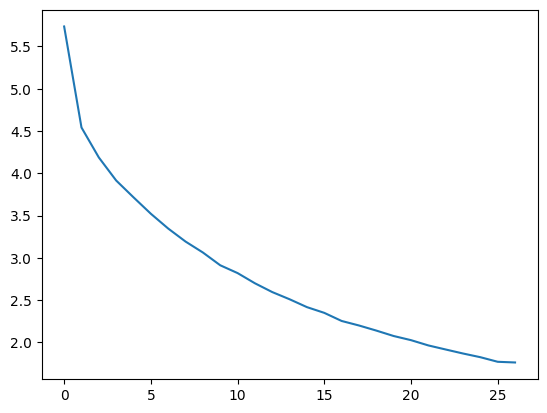

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


plt.figure()
plt.plot(all_losses)
plt.show()

# Evaluating the results

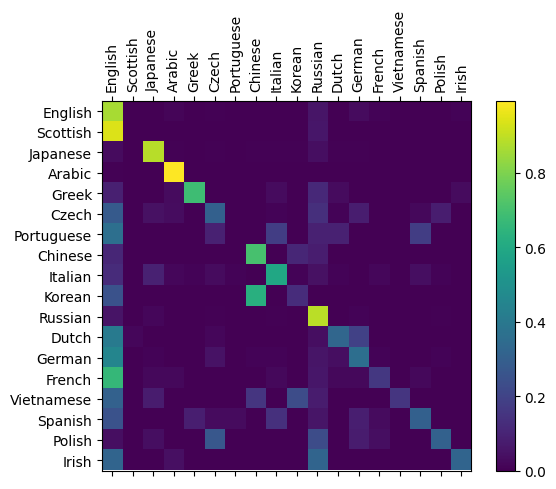

In [26]:
def evaluate(rnn, testing_data, classes):
  confusion = torch.zeros(len(classes), len(classes))

  rnn.eval() # set to eval mode
  with torch.no_grad():
    for i in range(len(testing_data)):
      (label_tensor, text_tensor, label, text) = testing_data[i]
      output = rnn(text_tensor)
      guess, guess_i = label_from_output(output, classes)
      label_i = classes.index(label)
      confusion[label_i][guess_i] += 1

  for i in range(len(classes)):
    denom = confusion[i].sum()
    if denom > 0:
      confusion[i] = confusion[i]/denom



  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
  ax.set_yticks(np.arange(len(classes)), labels=classes)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

evaluate(rnn, test_set, classes=alldata.labels_uniq)